In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import when
from pyspark.sql.functions import col
from pyspark.sql.types import * 
from pyspark.sql.functions import lit
from pyspark.sql.functions import to_date
import pyodbc
import pandas as pd
import pyspark.sql.functions as sf
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.config("spark.driver.memory", "9g").getOrCreate()

## Total User by Date

In [3]:
def calculate_data_daily_TotalUser(path,file):
    df = spark.read.json(path+file)
    df = df.select( '_source.Contract','_source.AppName', '_source.TotalDuration')
    df = df.withColumn("Type",
           when((col("AppName") == 'CHANNEL') | (col("AppName") =='DSHD')| (col("AppName") =='KPLUS')| (col("AppName") =='KPlus'), "Truyền Hình")
          .when((col("AppName") == 'VOD') | (col("AppName") =='FIMS_RES')| (col("AppName") =='BHD_RES')| 
                 (col("AppName") =='VOD_RES')| (col("AppName") =='FIMS')| (col("AppName") =='BHD')| (col("AppName") =='DANET'), "Phim Truyện")
          .when((col("AppName") == 'RELAX'), "Giải Trí")
          .when((col("AppName") == 'CHILD'), "Thiếu Nhi")
          .when((col("AppName") == 'SPORT'), "Thể Thao")
          .otherwise("Error"))
    calculation = df.select('Contract','Type','TotalDuration')
    return calculation.groupBy("Type","Contract").count().groupBy('Type').count()

In [4]:
def TotalUser(path, from_date, to_date):
    
    start = int(from_date[-2:])
    end = int(to_date[-2:])
    
    #create empty DataFrame
    schema = StructType([
        StructField('Type', StringType(), True),
        StructField('TotalUser', LongType(), True),
        StructField('Date', DateType(), True)
        ])
    data = spark.createDataFrame(spark.sparkContext.emptyRDD(),schema)
    
    #get data
    for i in range(start,end+1):
        if i<10:
            file = """2022040{}.json""".format(i)
            str_date = "2022-04-0{}"
        else:
            file = """202204{}.json""".format(i)
            str_date = "2022-04-{}"
        data_date = calculate_data_daily_TotalUser(path,file)
        data_date = data_date.withColumn("Date",lit(str_date.format(i)))
        data_date = data_date.withColumnRenamed("count","TotalUser")
        data = data.union(data_date)
        #data.cache()
    return data

In [27]:
path = "F:\\Study\\X-DATA\\Big Data\\DataSet\\"
from_date = "20220401"
to_date = "20220430"

In [8]:
#Total User by date
data_TotalUser = TotalUser(path, from_date,to_date)

In [9]:
data_TotalUser.cache()

DataFrame[Type: string, TotalUser: bigint, Date: string]

In [10]:
data_TotalUser.show()

+-----------+---------+----------+
|       Type|TotalUser|      Date|
+-----------+---------+----------+
|   Thể Thao|     2292|2022-04-01|
|Truyền Hình|  1355367|2022-04-01|
|  Thiếu Nhi|    33056|2022-04-01|
|   Giải Trí|     6394|2022-04-01|
|Phim Truyện|    86312|2022-04-01|
|   Thể Thao|     2261|2022-04-02|
|Truyền Hình|  1328138|2022-04-02|
|  Thiếu Nhi|    36406|2022-04-02|
|   Giải Trí|    14183|2022-04-02|
|Phim Truyện|    89110|2022-04-02|
|   Thể Thao|     2601|2022-04-03|
|Truyền Hình|  1314947|2022-04-03|
|  Thiếu Nhi|    35671|2022-04-03|
|   Giải Trí|     6192|2022-04-03|
|Phim Truyện|    88953|2022-04-03|
|   Thể Thao|     2386|2022-04-04|
|Truyền Hình|  1330592|2022-04-04|
|  Thiếu Nhi|    31857|2022-04-04|
|   Giải Trí|     6702|2022-04-04|
|Phim Truyện|    77408|2022-04-04|
+-----------+---------+----------+
only showing top 20 rows



In [11]:
data_TotalUser.printSchema()

root
 |-- Type: string (nullable = true)
 |-- TotalUser: long (nullable = true)
 |-- Date: string (nullable = true)



In [12]:
#Convert column Date to datetype

from pyspark.sql.functions import to_date
data_TotalUser = data_TotalUser.withColumn('Date',to_date(data_TotalUser.Date, 'yyyy-MM-dd'))

In [13]:
data_TotalUser.printSchema()

root
 |-- Type: string (nullable = true)
 |-- TotalUser: long (nullable = true)
 |-- Date: date (nullable = true)



In [14]:
#Pivot TotalUsser table

data_TotalUser_pivot = data_TotalUser.groupBy("Date").pivot("Type").sum("TotalUser")

In [15]:
data_TotalUser_pivot = data_TotalUser_pivot.cache()

In [16]:
data_TotalUser_pivot.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Error: long (nullable = true)
 |-- Giải Trí: long (nullable = true)
 |-- Phim Truyện: long (nullable = true)
 |-- Thiếu Nhi: long (nullable = true)
 |-- Thể Thao: long (nullable = true)
 |-- Truyền Hình: long (nullable = true)



In [17]:
data_TotalUser_pivot = data_TotalUser_pivot.sort("Date")

In [18]:
data_TotalUser_pivot = data_TotalUser_pivot.drop("Error")

In [19]:
data_TotalUser_pivot.show(30)

+----------+--------+-----------+---------+--------+-----------+
|      Date|Giải Trí|Phim Truyện|Thiếu Nhi|Thể Thao|Truyền Hình|
+----------+--------+-----------+---------+--------+-----------+
|2022-04-01|    6394|      86312|    33056|    2292|    1355367|
|2022-04-02|   14183|      89110|    36406|    2261|    1328138|
|2022-04-03|    6192|      88953|    35671|    2601|    1314947|
|2022-04-04|    6702|      77408|    31857|    2386|    1330592|
|2022-04-05|    5935|      81239|    31864|    2202|    1320852|
|2022-04-06|    5466|      81478|    31557|    4219|    1321137|
|2022-04-07|    5325|      82374|    31254|    4907|    1319626|
|2022-04-08|    5323|      83577|    32409|    3017|    1316502|
|2022-04-09|   13645|      88530|    36744|    3136|    1302486|
|2022-04-10|    6130|      88525|    34549|    2898|    1275622|
|2022-04-11|    6339|      90009|    36080|    3171|    1328889|
|2022-04-12|    5348|      78361|    30711|    1847|    1314168|
|2022-04-13|    5321|    

In [20]:
#export data

#data_TotalUser.repartition(1).write.csv('F:\\Study\\X-DATA\\Big Data\\Lession 4\\TotalUser',header=True)

In [21]:
df_TotalUser=data_TotalUser_pivot.toPandas()

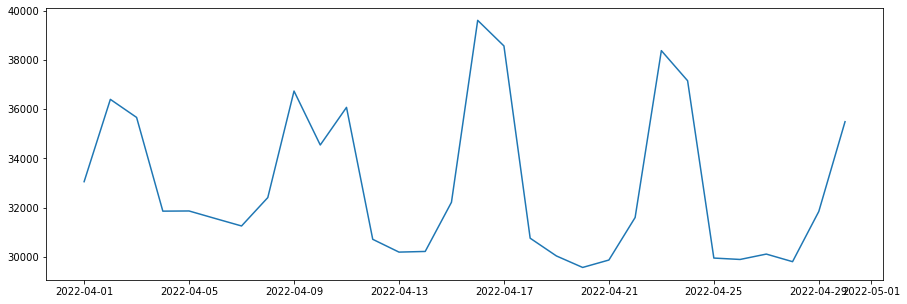

In [22]:
plt.figure(figsize=(15,5))
plt.plot(df_TotalUser.Date, df_TotalUser['Thiếu Nhi'])

**Nhận xét:** Số lượng User xem các chương trình *Thiếu Nhi* giao động theo chu kỳ, tăng cao vào các ngày nghỉ cuối tuần và hạ thấp vào các ngày trong tuần

## Total Duration by Date

In [25]:
def calculate_data_daily_TotalDuration(path,file):
    df = spark.read.json(path+file)
    df = df.select( '_source.Contract','_source.AppName', '_source.TotalDuration')
    #stateDic={'CHANNEL':'Truyền Hình','DSHD':'Truyền Hình', 'KPLUS':'Truyền Hình','VOD' : 'Phim truyen', 'FIMS': 'Phim truyen','SPORT': 'The thao', 'RELAX': 'Giai tri','CHILD': 'Thieu nhi'}
    #df=df.rdd.map(lambda x: (x.Contract,stateDic[x.AppName], x.TotalDuration)).toDF(["Contract","AppName","TotalDuration" ])
    df = df.withColumn("Type",
           when((col("AppName") == 'CHANNEL') | (col("AppName") =='DSHD')| (col("AppName") =='KPLUS')| (col("AppName") =='KPlus'), "Truyền Hình")
          .when((col("AppName") == 'VOD') | (col("AppName") =='FIMS_RES')| (col("AppName") =='BHD_RES')| 
                 (col("AppName") =='VOD_RES')| (col("AppName") =='FIMS')| (col("AppName") =='BHD')| (col("AppName") =='DANET'), "Phim Truyện")
          .when((col("AppName") == 'RELAX'), "Giải Trí")
          .when((col("AppName") == 'CHILD'), "Thiếu Nhi")
          .when((col("AppName") == 'SPORT'), "Thể Thao")
          .otherwise("Error"))
    calculation = df.select('Contract','Type','TotalDuration')
    calculation = df.groupBy('Type').sum("TotalDuration")
    calculation = calculation.withColumnRenamed('sum(TotalDuration)','TotalDuration')
    return calculation

In [26]:
def TotalDuration(path, from_date, to_date):
    
    start = int(from_date[-2:])
    end = int(to_date[-2:])
    
    #create empty DataFrame
    schema = StructType([
        StructField('Type', StringType(), True),
        StructField('TotalDuration', LongType(), True),
        StructField('Date', StringType(), True)
        ])
    data = spark.createDataFrame(spark.sparkContext.emptyRDD(),schema)
    
    #get data
    for i in range(start,end+1):
        if i<10:
            file = """2022040{}.json""".format(i)
            str_date = "2022-04-0{}"
        else:
            file = """202204{}.json""".format(i)
            str_date = "2022-04-{}"
        data_date = calculate_data_daily_TotalDuration(path,file)
        data_date = data_date.withColumn("Date",lit(str_date.format(i)))
        #data_date = data_date.withColumnRenamed("count","TotalUser")
        data = data.union(data_date)
        #data.cache()
    return data

In [ ]:
path = "F:\\Study\\X-DATA\\Big Data\\DataSet\\"
from_date = "20220401"
to_date = "20220430"

In [28]:
#Total Duration by date
data_TotalDuration = TotalDuration(path, from_date,to_date)

In [29]:
data_TotalDuration.cache()

DataFrame[Type: string, TotalDuration: bigint, Date: string]

In [30]:
data_TotalDuration.show()

+-----------+-------------+----------+
|       Type|TotalDuration|      Date|
+-----------+-------------+----------+
|   Thể Thao|      1166238|2022-04-01|
|Truyền Hình|  25210339682|2022-04-01|
|  Thiếu Nhi|    178570178|2022-04-01|
|   Giải Trí|     20907906|2022-04-01|
|Phim Truyện|    627150472|2022-04-01|
|   Thể Thao|      2304036|2022-04-02|
|Truyền Hình|  23447491078|2022-04-02|
|  Thiếu Nhi|    217096473|2022-04-02|
|   Giải Trí|     23660631|2022-04-02|
|Phim Truyện|    653793394|2022-04-02|
|   Thể Thao|      2089684|2022-04-03|
|Truyền Hình|  23448799428|2022-04-03|
|  Thiếu Nhi|    213572505|2022-04-03|
|   Giải Trí|     23482153|2022-04-03|
|Phim Truyện|    669111655|2022-04-03|
|   Thể Thao|      1270644|2022-04-04|
|Truyền Hình|  25023515316|2022-04-04|
|  Thiếu Nhi|    191329814|2022-04-04|
|   Giải Trí|     20926872|2022-04-04|
|Phim Truyện|    543324789|2022-04-04|
+-----------+-------------+----------+
only showing top 20 rows



In [31]:
data_TotalDuration.printSchema()

root
 |-- Type: string (nullable = true)
 |-- TotalDuration: long (nullable = true)
 |-- Date: string (nullable = true)



In [33]:
from pyspark.sql.functions import to_date

data_TotalDuration = data_TotalDuration.withColumn('Date',to_date(data_TotalDuration.Date, 'yyyy-MM-dd'))

In [34]:
data_TotalDuration.printSchema()

root
 |-- Type: string (nullable = true)
 |-- TotalDuration: long (nullable = true)
 |-- Date: date (nullable = true)



In [35]:
data_TotalDuration_pivot = data_TotalDuration.groupBy("Date").pivot("Type").sum("TotalDuration")

In [36]:
data_TotalDuration_pivot = data_TotalDuration_pivot.cache()

In [37]:
data_TotalDuration_pivot.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Error: long (nullable = true)
 |-- Giải Trí: long (nullable = true)
 |-- Phim Truyện: long (nullable = true)
 |-- Thiếu Nhi: long (nullable = true)
 |-- Thể Thao: long (nullable = true)
 |-- Truyền Hình: long (nullable = true)



In [38]:
data_TotalDuration_pivot = data_TotalDuration_pivot.sort("Date")

In [39]:
data_TotalDuration_pivot = data_TotalDuration_pivot.drop("Error")

In [40]:
data_TotalDuration_pivot.show(30)

+----------+--------+-----------+---------+--------+-----------+
|      Date|Giải Trí|Phim Truyện|Thiếu Nhi|Thể Thao|Truyền Hình|
+----------+--------+-----------+---------+--------+-----------+
|2022-04-01|20907906|  627150472|178570178| 1166238|25210339682|
|2022-04-02|23660631|  653793394|217096473| 2304036|23447491078|
|2022-04-03|23482153|  669111655|213572505| 2089684|23448799428|
|2022-04-04|20926872|  543324789|191329814| 1270644|25023515316|
|2022-04-05|19818708|  554389072|186712205| 1203614|24446474511|
|2022-04-06|18373133| -250954961|183110034| 6502695|24715443879|
|2022-04-07|17691561| -337304856|177306488| 8427514|24649587137|
|2022-04-08|17467392|  563753952|183150225| 4483760|24494399275|
|2022-04-09|22195899|  602534817|213931093| 2750505|23974575908|
|2022-04-10|23014479|  630958656|202776815| 1815888|23801151939|
|2022-04-11|22213260|  642495265|214704365| 2547798|25024377668|
|2022-04-12|18672117|  529461237|179024680| 1535580|24559436680|
|2022-04-13|18365304|  52

In [ ]:
#export data

#data_TotalDuration.repartition(1).write.csv('F:\\Study\\X-DATA\\Big Data\\Lession 4\\TotalUser',header=True)

In [41]:
df_TotalDuration=data_TotalDuration_pivot.toPandas()

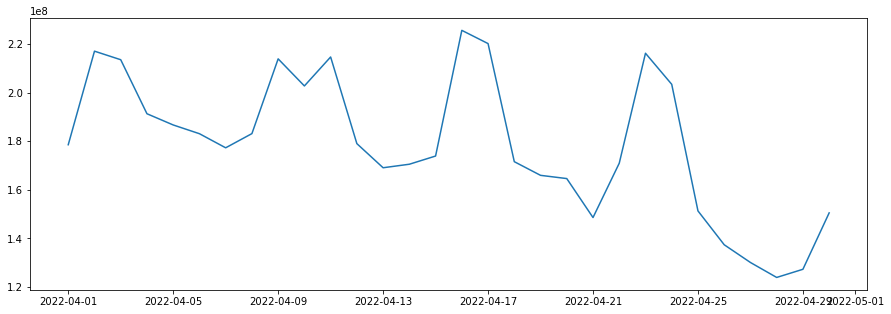

In [42]:
plt.figure(figsize=(15,5))
plt.plot(df_TotalDuration.Date, df_TotalDuration['Thiếu Nhi'])

Thời lượng xem các chương trình *Thiếu Nhi* tăng vào cuối tuần và giảm vào các ngày trong tuần

## Join Data

In [43]:
data_result = data_TotalDuration.join(data_TotalUser,['Type','Date'],'inner')

In [44]:
data_result = data_result.cache()

In [45]:
data_result.show()

+-----------+----------+-------------+---------+
|       Type|      Date|TotalDuration|TotalUser|
+-----------+----------+-------------+---------+
|   Thể Thao|2022-04-01|      1166238|     2292|
|Truyền Hình|2022-04-01|  25210339682|  1355367|
|  Thiếu Nhi|2022-04-01|    178570178|    33056|
|   Giải Trí|2022-04-01|     20907906|     6394|
|Phim Truyện|2022-04-01|    627150472|    86312|
|   Thể Thao|2022-04-02|      2304036|     2261|
|Truyền Hình|2022-04-02|  23447491078|  1328138|
|  Thiếu Nhi|2022-04-02|    217096473|    36406|
|   Giải Trí|2022-04-02|     23660631|    14183|
|Phim Truyện|2022-04-02|    653793394|    89110|
|   Thể Thao|2022-04-03|      2089684|     2601|
|Truyền Hình|2022-04-03|  23448799428|  1314947|
|  Thiếu Nhi|2022-04-03|    213572505|    35671|
|   Giải Trí|2022-04-03|     23482153|     6192|
|Phim Truyện|2022-04-03|    669111655|    88953|
|   Thể Thao|2022-04-04|      1270644|     2386|
|Truyền Hình|2022-04-04|  25023515316|  1330592|
|  Thiếu Nhi|2022-04

In [ ]:
#data_result.repartition(1).write.csv('F:\\Study\\X-DATA\\Big Data\\Lession 4\\TotalUser',header=True)

In [46]:
data_result.printSchema()

root
 |-- Type: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- TotalDuration: long (nullable = true)
 |-- TotalUser: long (nullable = true)



In [47]:
data_result.count()

151